# Notebook for Manifolder

Demonstration of the manifold reconstruction technique, using test data and space weather data.

The `simplified_data.csv` contains 8 channels of timeseries test data.  For simplicity, only the first channel contains the test signal, which contains a few different, repeating signal types.  All channels have low-level noise added, for numerical stability.

Running the `Manifolder` code with `Dim=3` projects the signal into an an underlying 3-dimensional manifold.  Plotting the signal, along with the underlying dimensions, gives a simple visual representation of the technique.

### Resources

[NumPy for Matlab users — NumPy v1.13 Manual](https://docs.scipy.org/doc/numpy-1.13.0/user/numpy-for-matlab-users.html)

[Getting Started with MATLAB](https://www.mathworks.com/help/matlab/getting-started-with-matlab.html)

### Running

This port strives to be as similar to the original MATLAB code as possible.  MATLAB code frequently runs the files inline, as scripts.  To do this in Python, we use the `exec()` command.

Executing files from within a notebook is useful for demonstration and debugging, since all the variables are avaible in the base naming space.

To run the code from the notebook, add the `manifolder_pkg` directory the `PYTHONPATH`.  An exammple in Bash would be:

```bash
PYTHONPATH=${PYTHONPATH}:~/Documents/repos/manifolder_repo/manifolder_pkg
```


In [6]:
!echo $PYTHONPATH

/Users/jonathan/Documents/repos:./:/Users/jonathan/Documents/repos/manifolder_repo/manifolder_pkg


In [7]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
!echo $PYTHONPATH

/Users/jonathan/Documents/repos:./:/Users/jonathan/Documents/repos/manifolder_repo/manifolder_pkg



*** executing load_data.py

loading data ... z.shape (8, 87660)
done!

*** executing histograms_overlap.py
calculating histograms for 8 dimensions (univariate timeseries) ........ done

*** executing covariances.py
computing local covariances .......... done

*** executing embedding.py
computing Dis matrix ..........done!
aniostropic kernel ... done
extending embedding (building Psi) ... done
*** executing clustering.py
running k-means
(17532,)
normalizing amplitueds of Psi in Python ...
(17524,)
done

	 Program Executed in 222.39 seconds
DONE


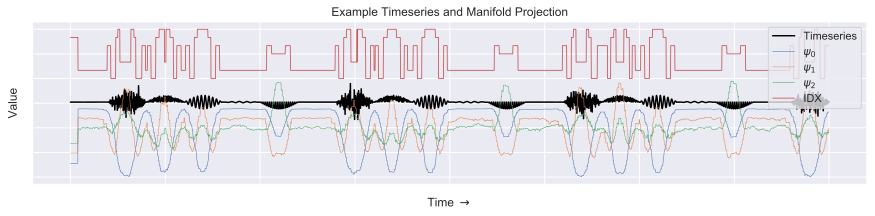

In [4]:
### THIS RUNS THE ENTIRE CODE, HERE
#   can also run subsections individually

exec(open('manifolder_pkg/main.py').read())

print('DONE')

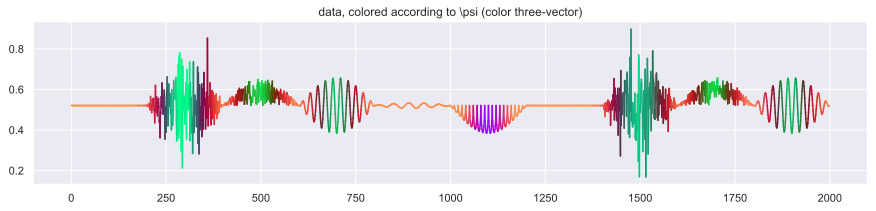

In [27]:
plt.figure(figsize=[15, 3])

for i in range(lim-1):
    col = [r[i],g[i],b[i]]
    plt.plot([i,i+1],[val[i],val[i+1]],color=col)

plt.title('data, colored according to Psi (color three-vector)')
    
plt.show()

In [ ]:
# IDX contains the index of clusters (typically ~7) ...
# need to make a dictionary, with a key for each index (0 to 6),
# the value is a list of the collection of lengths

In [ ]:
# ### count the cluster sizes

# # use a as the test array
# #a = np.array([0, 0, 0, 5, 5, 0, 0, 1, 1, 4])
# a = IDX

# print('using',a)

# keys = np.unique( a )
# np.sort(keys)  # happens in place
# print('cluster names (keys)',keys)

# # create dictionary with empty lists
# cluster_lens = {key: [] for key in keys}

# #print(np.array)

# # find the matching values
# i = 0
# while( i<a.size):
#     this_val = a[i]
#     d = np.where(a[i:] != this_val)[0] # find where the value changes
#     #print(d)
#     if d.size > 0:
#         # now know how many points, before the value changes
#         #print('lol')
#         this_len = d[0] # first location that is not this_val
#         #print('this_len',this_len)
#     else:
#         this_len = a.size - i
    
#     # this_val is the custer
#     # this_len is the length of that cluster
#     # ... store it!
#     cluster_lens[this_val].append(this_len)
#     #print(str(this_val),str(this_len))
    
#     #print(d)
#     i += this_len
    


In [9]:
mh.test_count_cluster_lengths()
#count_cluster_lengths(IDX)

cluster names (keys) [0 1 4 5]
key 0 value [2, 3] 

key 1 value [2] 

key 4 value [1] 

key 5 value [2] 



In [11]:
# clustereing data ...

cluster_lens = mh.count_cluster_lengths( IDX )

# cluster_lens of a dictonary, where each key is the cluster number (0:6),
# and the values are a list of clusner lengths


cluster names (keys) [0 1 2 3 4 5 6]


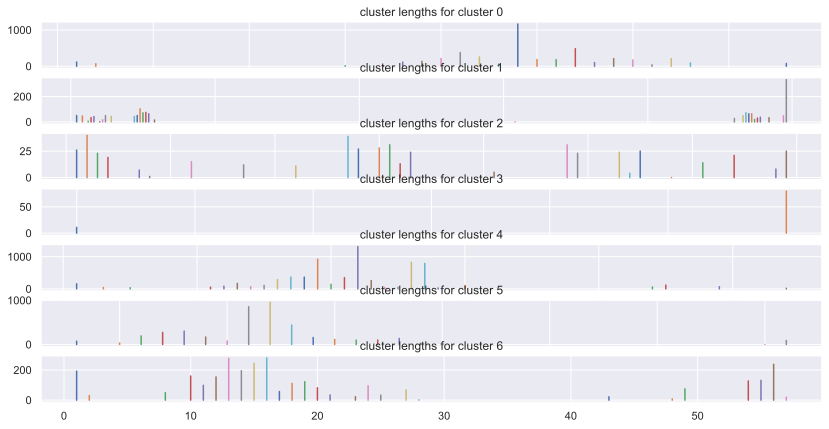

In [13]:
mh.show_cluster_lens( cluster_lens )

In [14]:
import matplotlib
cmap = matplotlib.cm.get_cmap('Spectral')

def sqrtbp(x):
    return np.sign(x) * np.sqrt(np.abs(x))

In [15]:
# okay, loop through data 
lim = 2000

val = xref1[:lim]
idx = IDX[:lim]

r = xs[:lim]
g = ys[:lim]
b = zs[:lim]

# prevent the jump in data value
r[:H] = r[H]
g[:H] = g[H]
b[:H] = b[H]

# r = np.diff(r)
# g = np.diff(g)
# b = np.diff(b)

# r = sqrtbp(r)
# g = sqrtbp(g)
# b = sqrtbp(b)

r -= np.min(r)
r /= np.max(r)

g -= np.min(g)
g /= np.max(g)

b -= np.min(b)
b /= np.max(b)

idx = 1.*idx  # cast to float
idx -= np.min(idx)
idx /= np.max(idx)

#plt.plot(val)
#plt.plot(idx)
       

In [16]:
# plt.figure(figsize=[15, 3])

# for i in range(lim-1):
#     col = cmap(idx[i])
#     plt.plot([i,i+1],[val[i],val[i+1]],color=col)

# plt.show()

In [18]:
z.shape

(8, 87660)

In [19]:
# extend out the simple data, to include the derivative (in the second channel)

In [20]:
print(z.shape)

(8, 87660)


In [21]:
p

NameError: name 'p' is not defined

### graph out state transition matrix

... this should be really cool, lol ...

In [ ]:
# in this case, index goes from 0 to 6 ... 
# can also have outlier groups in kmeans, need to check for this

print(IDX.shape)
print(np.min(IDX))
print(np.max(IDX))

IDX_max = np.max(IDX)



In [ ]:
#IDX = new_idx

In [ ]:
def make_transition_matrix( states ):
    """ transition matrix of a bunch of states (like IDX)"""
    states_max = np.max(states)

    tmat = np.zeros((states_max+1,states_max+1))

    # note, transition matrix is written with the 
    #   STATES AS COLUMNS, as in quantum mechanics / physics
    # 
    # evolution is then:
    #   |state+1> = tmat @ |state>
    #
    # (but need to normalize tmat)
    #

    for i in range(states.size-1):
        # states[i+1] is valid
        state_from = states[i]
        state_to = states[i+1]
        tmat[state_to,state_from] += 1
        
    return tmat

tmat = make_transition_matrix(IDX)
print('\n transition matrix:')
print(tmat)

In [ ]:
def make_matrix_markov( A ):
    """ takes a matrix, and normalizes so that each column sums to one
        (assumes matrix values are already positive!)"""
    # makes more sense to normalize so that the columns sum to one
    col_sum = np.sum(A,axis=0).reshape(1,-1)

    # print(col_sum)
    
    A_markov = A / col_sum # col_sum will broadcast

    return A_markov

#A = np.random.randn(3,3)

#print(A)

#print(make_matrix_markov(A))

In [ ]:
def imaget(data,vmax=None):
    """ t for transition matrix"""
    plt.figure(figsize=(7,7))
    
    # create scaled data
    if vmax is None:
        vmax = np.max(np.abs(data))

    #cmap = 'gist_heat'
    #cmap = 'bone'
    cmap = 'hot'
    #cmap = 'binary'
    plt.imshow(data,vmin=0,vmax=vmax,cmap=cmap)
    
    plt.grid(b=None)
    
    plt.xlabel('from')
    plt.ylabel('to')

    plt.colorbar()
    
    plt.title('transition matrix')
    
    plt.show()
    
print(tmat)
    
imaget(tmat)

In [ ]:
# remove diagonal, and make markov, for display

np.fill_diagonal( tmat, 0 ) # happens inplace
tmat = make_matrix_markov( tmat )

print(tmat)
print('tmat, not ordered')
imaget(tmat,1)


In [ ]:
# okay ... need to reorder, based on the transistions ...
from collections import OrderedDict

# reorder index, here
def reorder_cluster( IDX, tmat ):
    idx_freq = tmat.diagonal()
    
    new_idx = np.zeros_like(IDX)

    # sort the values of the index, from largest to smallest
    new_order = np.argsort(idx_freq)[::-1]

    for i in range(len(new_order)):
        # find all the locations matching next index needed
        loc = np.where(IDX==new_order[i])
        new_idx[loc] = i    # reorder, starting with i

    return new_idx

# newly reindexed

# remake the transition matrix, unmodified
tmat = make_transition_matrix(IDX)

new_idx = reorder_cluster(IDX,tmat)

tmat = make_transition_matrix(new_idx)  # make with new idex

print(tmat)

np.fill_diagonal( tmat, 0 ) # happens inplace
tmat = make_matrix_markov( tmat )

print(tmat)

In [ ]:
print('transition matrix, after reordering')
imaget(tmat,1)

In [ ]:
### print
# okay!  do the same thing, on k-means clustered data?
print(z.shape)
print(Psi.shape)

# note that Psi effectively is the transpose of z,
# decimated by a factor of z

In [ ]:
# this was the line
#kmeans = KMeans(n_clusters=numClusters).fit(Psi[:, :intrinsicDim])
#IDX = kmeans.labels_

In [ ]:
# cluster on the raw data (z, not Phi)
kmeans2 = KMeans(n_clusters=numClusters).fit(z.T)
IDX2 = kmeans2.labels_

In [ ]:
# cool, now have the other index!
tmat2 = make_transition_matrix(IDX2)

new_idx2 = reorder_cluster(IDX2,tmat2)

tmat2 = make_transition_matrix(new_idx2)  # make with new idex

print(tmat2)

imaget(tmat2)

tmat2 = make_matrix_markov( tmat2 )

# print(tmat2)





In [ ]:
np.fill_diagonal( tmat2, 0 ) # happens inplace
tmat2 = make_matrix_markov( tmat2 )

print(tmat2)

imaget(tmat2,1)

### tSNE

In [ ]:
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
print('X.shape',X.shape)
X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)


In [ ]:
# number of dimensions are assumed to be number of rows, for TSNE
# (use transpose)

start_time = time.time()


# shorten by five
# this is set by a "stride" somewhere?
z_short = z[:,::5]
print('z.shape',z.shape)
print('z_short.shape',z_short.shape)

z_embedded = TSNE(n_components=3).fit_transform(z_short.T)

elapsed = time.time() - start_time

print('elapsed mins:',np.round(elapsed/60,2))

In [ ]:
print('z_embedded.shape',z_embedded.shape)

lim = 4000

plt.figure(figsize=[15, 3])

xref = z[0,:lim]
# from tsne
xs = z_embedded[:lim,0] / 20 # careful (transposed)
ys = z_embedded[:lim,1] / 20 
zs = z_embedded[:lim,2] / 20 

# from manifolder
# xs = Psi[:lim, 0]   # this is shapped differently ...
# ys = Psi[:lim, 1] # this is shapped differently ...
# zs = Psi[:lim, 2] # this is shapped differently ...

plt.plot(xref, color='black',label='Timeseries')
plt.plot(xs, linewidth=.5,label='$\psi_0$')
plt.plot(ys, linewidth=.5,label='$\psi_1$')
plt.plot(zs[:lim], linewidth=.5,label='$\psi_2$')

# plt.plot(IDX[:lim]/np.max(IDX)+1,linewidth=.8,label='IDX')

plt.legend()

plt.xlabel('Time $ \\rightarrow $')
plt.ylabel('Value')

In [ ]:
mh.get_log_spaced_bins()

In [22]:
assert False

AssertionError: 

<Figure size 432x288 with 0 Axes>

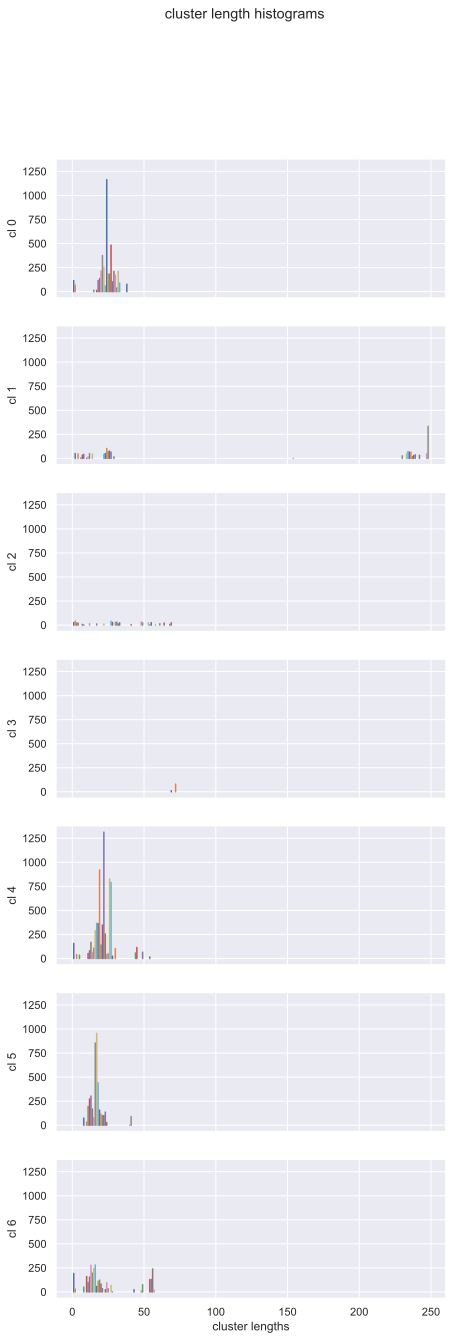

In [23]:
def show_cluster_lens(cluster_lens):
    """ plots the lengths of the clusters, as determined above """
    keys = list(cluster_lens.keys())
    nkeys = len(keys)
    
    # 
    xlim=0
    ylim=0

    plt.figure()
    
    fig, axes =  plt.subplots(nkeys, 1, sharex=True, sharey=True, figsize=[7,nkeys*3])

    # loop through, and make all the histograms, as subplots
    for k in range(nkeys):
        key = keys[k]
        
        different_lengths_this_cluster = np.unique(cluster_lens[key])

        for l in different_lengths_this_cluster:
            number_of_occurrences = np.sum(np.where(cluster_lens[key] == l)[0])
            #print('length', l, 'number_of_occurrences', number_of_occurrences)

            # plot as a vertical bar
            axes[k].plot([l, l], [0, number_of_occurrences])

        #xmax = axis.get_xlim()[1]  # second value of the limit is the range of graph
        #ymax = axis.get_ylim()[1]
        
        # the limit is the max of all the graphs
        #xlim = np.max((xlim,xmax))
        #ylim = np.max((ylim,ymax))
        
        axes[k].set_ylabel('cl ' + str(k))
        
        # find the limits of this plot, use to unify the axis (all graphs on same axis)
    
    # loop through and set the axis limit on the graphs 
    #for ax in axes:
    #    print(ax)
    #    #ax.set_xlim( (0, xlim) )
    #    ax.set_ylim( (0, ylim) )

    plt.suptitle( 'cluster length histograms')
    plt.xlabel("cluster lengths")
    plt.show()
    
        
show_cluster_lens( cluster_lens )

In [24]:
def reorder_clusters( IDX ):
    """ if IDX is a series of cluster values (2, 2, 2, 0, 0, 0, 4, 0 ),
        function will rename these, to appear in order (0, 0, 0, 1, 1, 1, 2, 1) """
    
    

In [25]:
z.shape

(8, 87660)

In [ ]:
np.max((1,2))